In [1]:
# ==========================================
# [Part 1] 환경 설정 및 한글 폰트 설치
# ==========================================
# 시각화 그래프에서 한글이 깨지지 않도록 '나눔바른고딕' 폰트를 설치합니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

print("✅ 폰트 설치 완료! [Part 2]를 실행하여 런타임을 재시작해주세요.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,954 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and dire

In [ ]:
# ==========================================
# [Part 2] 런타임 자동 재시작 (폰트 적용)
# ==========================================
import os
print("⏳ 폰트 적용을 위해 런타임을 재시작합니다...")
os.kill(os.getpid(), 9)

In [2]:
import pandas as pd
# 파일명이 정확해야 합니다
df = pd.read_csv('CountriesChangePr.csv')
print(list(df.columns))

['Unnamed: 0', '[Omission -> Commission]: Estimates', '[Passengers -> Pedestrians]: Estimates', 'Law [Illegal -> Legal]: Estimates', 'Gender [Male -> Female]: Estimates', 'Fitness [Large -> Fit]: Estimates', 'Social Status [Low -> High]: Estimates', 'Age [Elderly -> Young]: Estimates', 'No. Characters [Less -> More]: Estimates', 'Species [Pets -> Humans]: Estimates', '[Omission -> Commission]: se', '[Passengers -> Pedestrians]: se', 'Law [Illegal -> Legal]: se', 'Gender [Male -> Female]: se', 'Fitness [Large -> Fit]: se', 'Social Status [Low -> High]: se', 'Age [Elderly -> Young]: se', 'No. Characters [Less -> More]: se', 'Species [Pets -> Humans]: se']


In [3]:
# ==========================================
# [Part 3] 데이터 구축: 원본 데이터 로드 및 전처리
# ==========================================
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# 1. 시각화 환경 설정
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

print("⏳ 원본 CSV 데이터를 로드하고 전처리(정제 -> 변환 -> 정규화) 중입니다...")

# -------------------------------------------------------
# Step 1. 원본 데이터 로드 (Data Loading)
# -------------------------------------------------------
csv_file = 'CountriesChangePr.csv'

if os.path.exists(csv_file):
    raw_df = pd.read_csv(csv_file)

    # [Big Data 기법 1] 데이터 표준화: 모든 컬럼명을 소문자로 통일 (대소문자 오류 방지)
    raw_df.columns = raw_df.columns.str.lower()
    print(f"✅ 원본 파일 로드 성공! (총 {len(raw_df)}개 국가 데이터)")

    # -------------------------------------------------------
    # Step 2. 컬럼 매핑 및 정제 (Data Cleaning & Mapping)
    # -------------------------------------------------------
    # [Big Data 기법 2] 변수 매핑: 복잡한 원본 컬럼명을 직관적인 분석 용어로 변경
    rename_map = {
        'unnamed: 0': 'ISO3',
        'age [elderly -> young]: estimates': 'save_young',        # 젊은이 선호
        'law [illegal -> legal]: estimates': 'compliance',        # 법규 준수
        'gender [male -> female]: estimates': 'save_female',      # 여성 선호
        'no. characters [less -> more]: estimates': 'save_many',  # 다수 선호
        'fitness [large -> fit]: estimates': 'save_fit'           # 건강 선호
    }
    df = raw_df.rename(columns=rename_map)

    # [Big Data 기법 3] 파생 변수 생성: '노인 선호' 지표 생성 (젊은이 선호의 역수 개념)
    if 'save_young' in df.columns:
        df['save_elderly'] = -df['save_young']
    else:
        df['save_young'] = 0.5
        df['save_elderly'] = 0.5

    # -------------------------------------------------------
    # Step 3. 데이터 스케일링 (Min-Max Scaling)
    # -------------------------------------------------------
    # [Big Data 기법 4] 정규화: 서로 다른 범위의 데이터를 0~1 사이로 변환하여 비교 가능하게 만듦
    cols_to_scale = ['save_young', 'save_elderly', 'compliance', 'save_female', 'save_many']

    for col in cols_to_scale:
        if col in df.columns:
            min_val = df[col].min()
            max_val = df[col].max()
            if max_val != min_val:
                df[col] = (df[col] - min_val) / (max_val - min_val)
            else:
                df[col] = 0.5
        else:
            df[col] = 0.5 # 결측 컬럼 처리

    # -------------------------------------------------------
    # Step 4. 분석 대상 필터링 (Filtering)
    # -------------------------------------------------------
    # 데이터 신뢰도가 확보된 주요 52개국 추출
    target_iso = [
        'KOR', 'JPN', 'CHN', 'TWN', 'SGP', 'VNM', 'THA', 'IDN', 'PHL', 'MYS', 'IND', 'PAK', 'SAU', 'ARE', 'TUR', 'IRN', 'ISR', 'RUS', 'KAZ',
        'GBR', 'FRA', 'DEU', 'ITA', 'ESP', 'PRT', 'NLD', 'BEL', 'CHE', 'AUT', 'SWE', 'NOR', 'DNK', 'FIN', 'POL', 'CZE', 'HUN', 'GRC', 'IRL',
        'USA', 'CAN', 'MEX', 'BRA', 'ARG', 'CHL', 'COL', 'PER',
        'AUS', 'NZL', 'EGY', 'ZAF', 'NGA', 'KEN'
    ]

    if 'ISO3' in df.columns:
        df = df[df['ISO3'].isin(target_iso)].copy()

        # 한글 국가명 매핑 (시각화 가독성 향상)
        country_map = {
            'KOR': '대한민국', 'JPN': '일본', 'CHN': '중국', 'TWN': '대만', 'SGP': '싱가포르', 'VNM': '베트남', 'THA': '태국', 'IDN': '인도네시아', 'PHL': '필리핀', 'MYS': '말레이시아',
            'IND': '인도', 'PAK': '파키스탄', 'SAU': '사우디', 'ARE': 'UAE', 'TUR': '터키', 'IRN': '이란', 'ISR': '이스라엘', 'RUS': '러시아', 'KAZ': '카자흐스탄',
            'GBR': '영국', 'FRA': '프랑스', 'DEU': '독일', 'ITA': '이탈리아', 'ESP': '스페인', 'PRT': '포르투갈', 'NLD': '네덜란드', 'BEL': '벨기에', 'CHE': '스위스', 'AUT': '오스트리아',
            'SWE': '스웨덴', 'NOR': '노르웨이', 'DNK': '덴마크', 'FIN': '핀란드', 'POL': '폴란드', 'CZE': '체코', 'HUN': '헝가리', 'GRC': '그리스', 'IRL': '아일랜드',
            'USA': '미국', 'CAN': '캐나다', 'MEX': '멕시코', 'BRA': '브라질', 'ARG': '아르헨티나', 'CHL': '칠레', 'COL': '콜롬비아', 'PER': '페루',
            'AUS': '호주', 'NZL': '뉴질랜드', 'EGY': '이집트', 'ZAF': '남아공', 'NGA': '나이지리아', 'KEN': '케냐'
        }

        df['Country'] = df['ISO3'].map(country_map)
        df['Country'] = df['Country'].fillna(df['ISO3']) # 매핑 실패 시 코드로 대체

        # -------------------------------------------------------
        # Step 5. 최종 데이터셋 생성
        # -------------------------------------------------------
        final_cols = ['ISO3', 'Country'] + cols_to_scale
        df = df[final_cols]

        df.to_csv("moral_machine_final_data.csv", index=False)
        print(f"✅ 전처리 완료! {len(df)}개 국가 데이터를 성공적으로 추출했습니다.")
        print(df.head()) # [PPT 캡처용] 최종 데이터 표 확인


    else:
        print("❌ 오류: 'ISO3' 컬럼 매핑 실패. 원본 데이터 구조를 확인하세요.")
else:
    print(f"❌ 오류: '{csv_file}' 파일을 찾을 수 없습니다.")


df.head(10).style.background_gradient(cmap='Blues')

⏳ 원본 CSV 데이터를 로드하고 전처리(정제 -> 변환 -> 정규화) 중입니다...
✅ 원본 파일 로드 성공! (총 130개 국가 데이터)
✅ 전처리 완료! 52개 국가 데이터를 성공적으로 추출했습니다.
   ISO3 Country  save_young  save_elderly  compliance  save_female  save_many
4   ARE     UAE    0.377813      0.622187    0.462928     0.422907   0.640970
5   ARG   아르헨티나    0.555313      0.444687    0.406574     0.493313   0.545519
7   AUS      호주    0.551243      0.448757    0.349594     0.403130   0.661964
8   AUT   오스트리아    0.536633      0.463367    0.519593     0.340169   0.606082
10  BEL     벨기에    0.529245      0.470755    0.539783     0.486807   0.591526


,ISO3,Country,save_young,save_elderly,compliance,save_female,save_many
4,ARE,UAE,0.377813,0.622187,0.462928,0.422907,0.640970
5,ARG,아르헨티나,0.555313,0.444687,0.406574,0.493313,0.545519
7,AUS,호주,0.551243,0.448757,0.349594,0.403130,0.661964
8,AUT,오스트리아,0.536633,0.463367,0.519593,0.340169,0.606082
10,BEL,벨기에,0.529245,0.470755,0.539783,0.486807,0.591526
18,BRA,브라질,0.456388,0.543612,0.501619,0.509345,0.434641
21,CAN,캐나다,0.567462,0.432538,0.368689,0.411436,0.691474
22,CHE,스위스,0.453369,0.546631,0.527146,0.390875,0.545982
23,CHL,칠레,0.458857,0.541143,0.544950,0.534225,0.501693
24,CHN,중국,0.079414,0.920586,0.624688,0.383003,0.212993


In [4]:
# ==========================================
# [Part 4] 거시 분석: 전 세계 윤리적 성향 지도
# ==========================================
import plotly.express as px

print("⏳ 평면 지도를 생성하고 있습니다...")

# 1. 지도 시각화 생성 (Choropleth Map)
fig = px.choropleth(
    df,
    locations="ISO3",
    color="save_young",
    hover_name="Country",
    color_continuous_scale='RdBu', # Red(동양/노인) <-> Blue(서양/젊은이)
    range_color=[0.3, 0.7],        # 색상 대비 최적화
    title="<b>[거시 분석] 전 세계 윤리 성향: 젊은이 선호도 (Save Young)</b>",
    labels={'save_young': '젊은이 선호 지수'}
)

# 2. 레이아웃 설정 (평면 지도)
fig.update_layout(
    title_font_size=20,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth',
        showocean=True, oceancolor="#F0F8FF",
        showlakes=True, lakecolor="#F0F8FF"
    ),
    margin={"r":0,"t":50,"l":0,"b":0}
)

# 3. 출력 설정 (스크롤 확대 방지)
fig.show(config={
    'scrollZoom': False,
    'displayModeBar': True,
    'displaylogo': False
})

fig.write_html("moral_machine_map.html")
print("✅ 지도 생성 완료! (오른쪽 상단 카메라 아이콘으로 다운로드)")

⏳ 평면 지도를 생성하고 있습니다...


✅ 지도 생성 완료! (오른쪽 상단 카메라 아이콘으로 다운로드)


In [12]:
# ==========================================
# [Part 4-1] 머신러닝: K-Means 클러스터링 (그룹명/색상 지정)
# ==========================================
from sklearn.cluster import KMeans
import plotly.express as px

print("⏳ AI가 국가들을 성향별로 그룹화하고 이름을 붙이고 있습니다...")

# 1. 학습 데이터 준비
features = ['save_young', 'save_elderly', 'compliance', 'save_female', 'save_many']
X = df[features]

# 2. K-Means 모델 학습
# random_state=42로 고정하여 결과가 바뀌지 않게 함
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X)

# 3. 그룹 이름 매핑 (Naming)
# 아까 나온 결과(미국=0, 러시아=1, 중국=2)를 바탕으로 이름 부여
cluster_names = {
    0: '서구형: 효율/미래 중시',  # 미국, 유럽 쪽
    2: '동양형: 규범/질서 중시',  # 아시아 쪽
    1: '복합형: 보호/중간 성향'   # 러시아, 남미 쪽
}
df['Cluster_Label'] = df['Cluster'].map(cluster_names)

# 4. 색상 지정 (Color Mapping)
# 서양=파랑, 동양=빨강, 나머지=초록
color_map = {
    '서구형: 효율/미래 중시': '#1E88E5', # Blue
    '동양형: 규범/질서 중시': '#D32F2F', # Red
    '복합형: 보호/중간 성향': '#43A047'  # Green
}

# 5. 지도 시각화
fig = px.choropleth(
    df,
    locations="ISO3",
    color="Cluster_Label",      # 그룹 이름으로 색칠
    hover_name="Country",
    title="<b>[머신러닝] AI가 분류한 문화권별 윤리 성향 지도 (K-Means)</b>",
    color_discrete_map=color_map, # 우리가 정한 색상 적용
    labels={'Cluster_Label': 'AI 분류 그룹'} # 범례 제목
)

fig.update_layout(
    title_font_size=20,
    geo=dict(
        showframe=False, showcoastlines=True, projection_type='natural earth',
        showocean=True, oceancolor="#F0F8FF", showlakes=True, lakecolor="#F0F8FF"
    ),
    margin={"r":0,"t":50,"l":0,"b":0}
)

# 6. 출력 및 저장
fig.show(config={'scrollZoom': False, 'displayModeBar': True})
fig.write_html("moral_machine_kmeans_map.html")

print("✅ 그룹명 변경 완료! 지도의 범례(Legend)를 확인하세요.")

⏳ AI가 국가들을 성향별로 그룹화하고 이름을 붙이고 있습니다...


✅ 그룹명 변경 완료! 지도의 범례(Legend)를 확인하세요.


In [16]:
# ---------------------------------------------------------
# [추가] AI가 분류한 그룹별 성향 평균 점수
# ---------------------------------------------------------

# 1. 그룹별 평균 계산
group_means = df.groupby('Cluster_Label')[['save_young', 'compliance', 'save_elderly', 'save_many']].mean()

# 2. 컬럼 이름을 한글로 변경
kor_cols = {
    'save_young': '젊은이 선호',
    'compliance': '법규 준수',
    'save_elderly': '노인 선호',
    'save_many': '다수 선호'
}
group_means_ko = group_means.rename(columns=kor_cols)

# 3. 보기 좋게 색깔 입혀서 출력
print("📊 [AI 분류 그룹별 성향 평균 점수]")
print("👉 색상이 진할수록 해당 성향이 강하다는 뜻입니다.")

display(group_means_ko.style.format("{:.2f}").background_gradient(cmap='Blues'))

📊 [AI 분류 그룹별 성향 평균 점수]
👉 색상이 진할수록 해당 성향이 강하다는 뜻입니다.


,젊은이 선호,법규 준수,노인 선호,다수 선호
Cluster_Label,,,,
동양형: 규범/질서 중시,0.16,0.56,0.84,0.23
복합형: 보호/중간 성향,0.42,0.44,0.58,0.50
서구형: 효율/미래 중시,0.58,0.44,0.42,0.62


⏳ 챔피언 차트를 생성하고 있습니다...


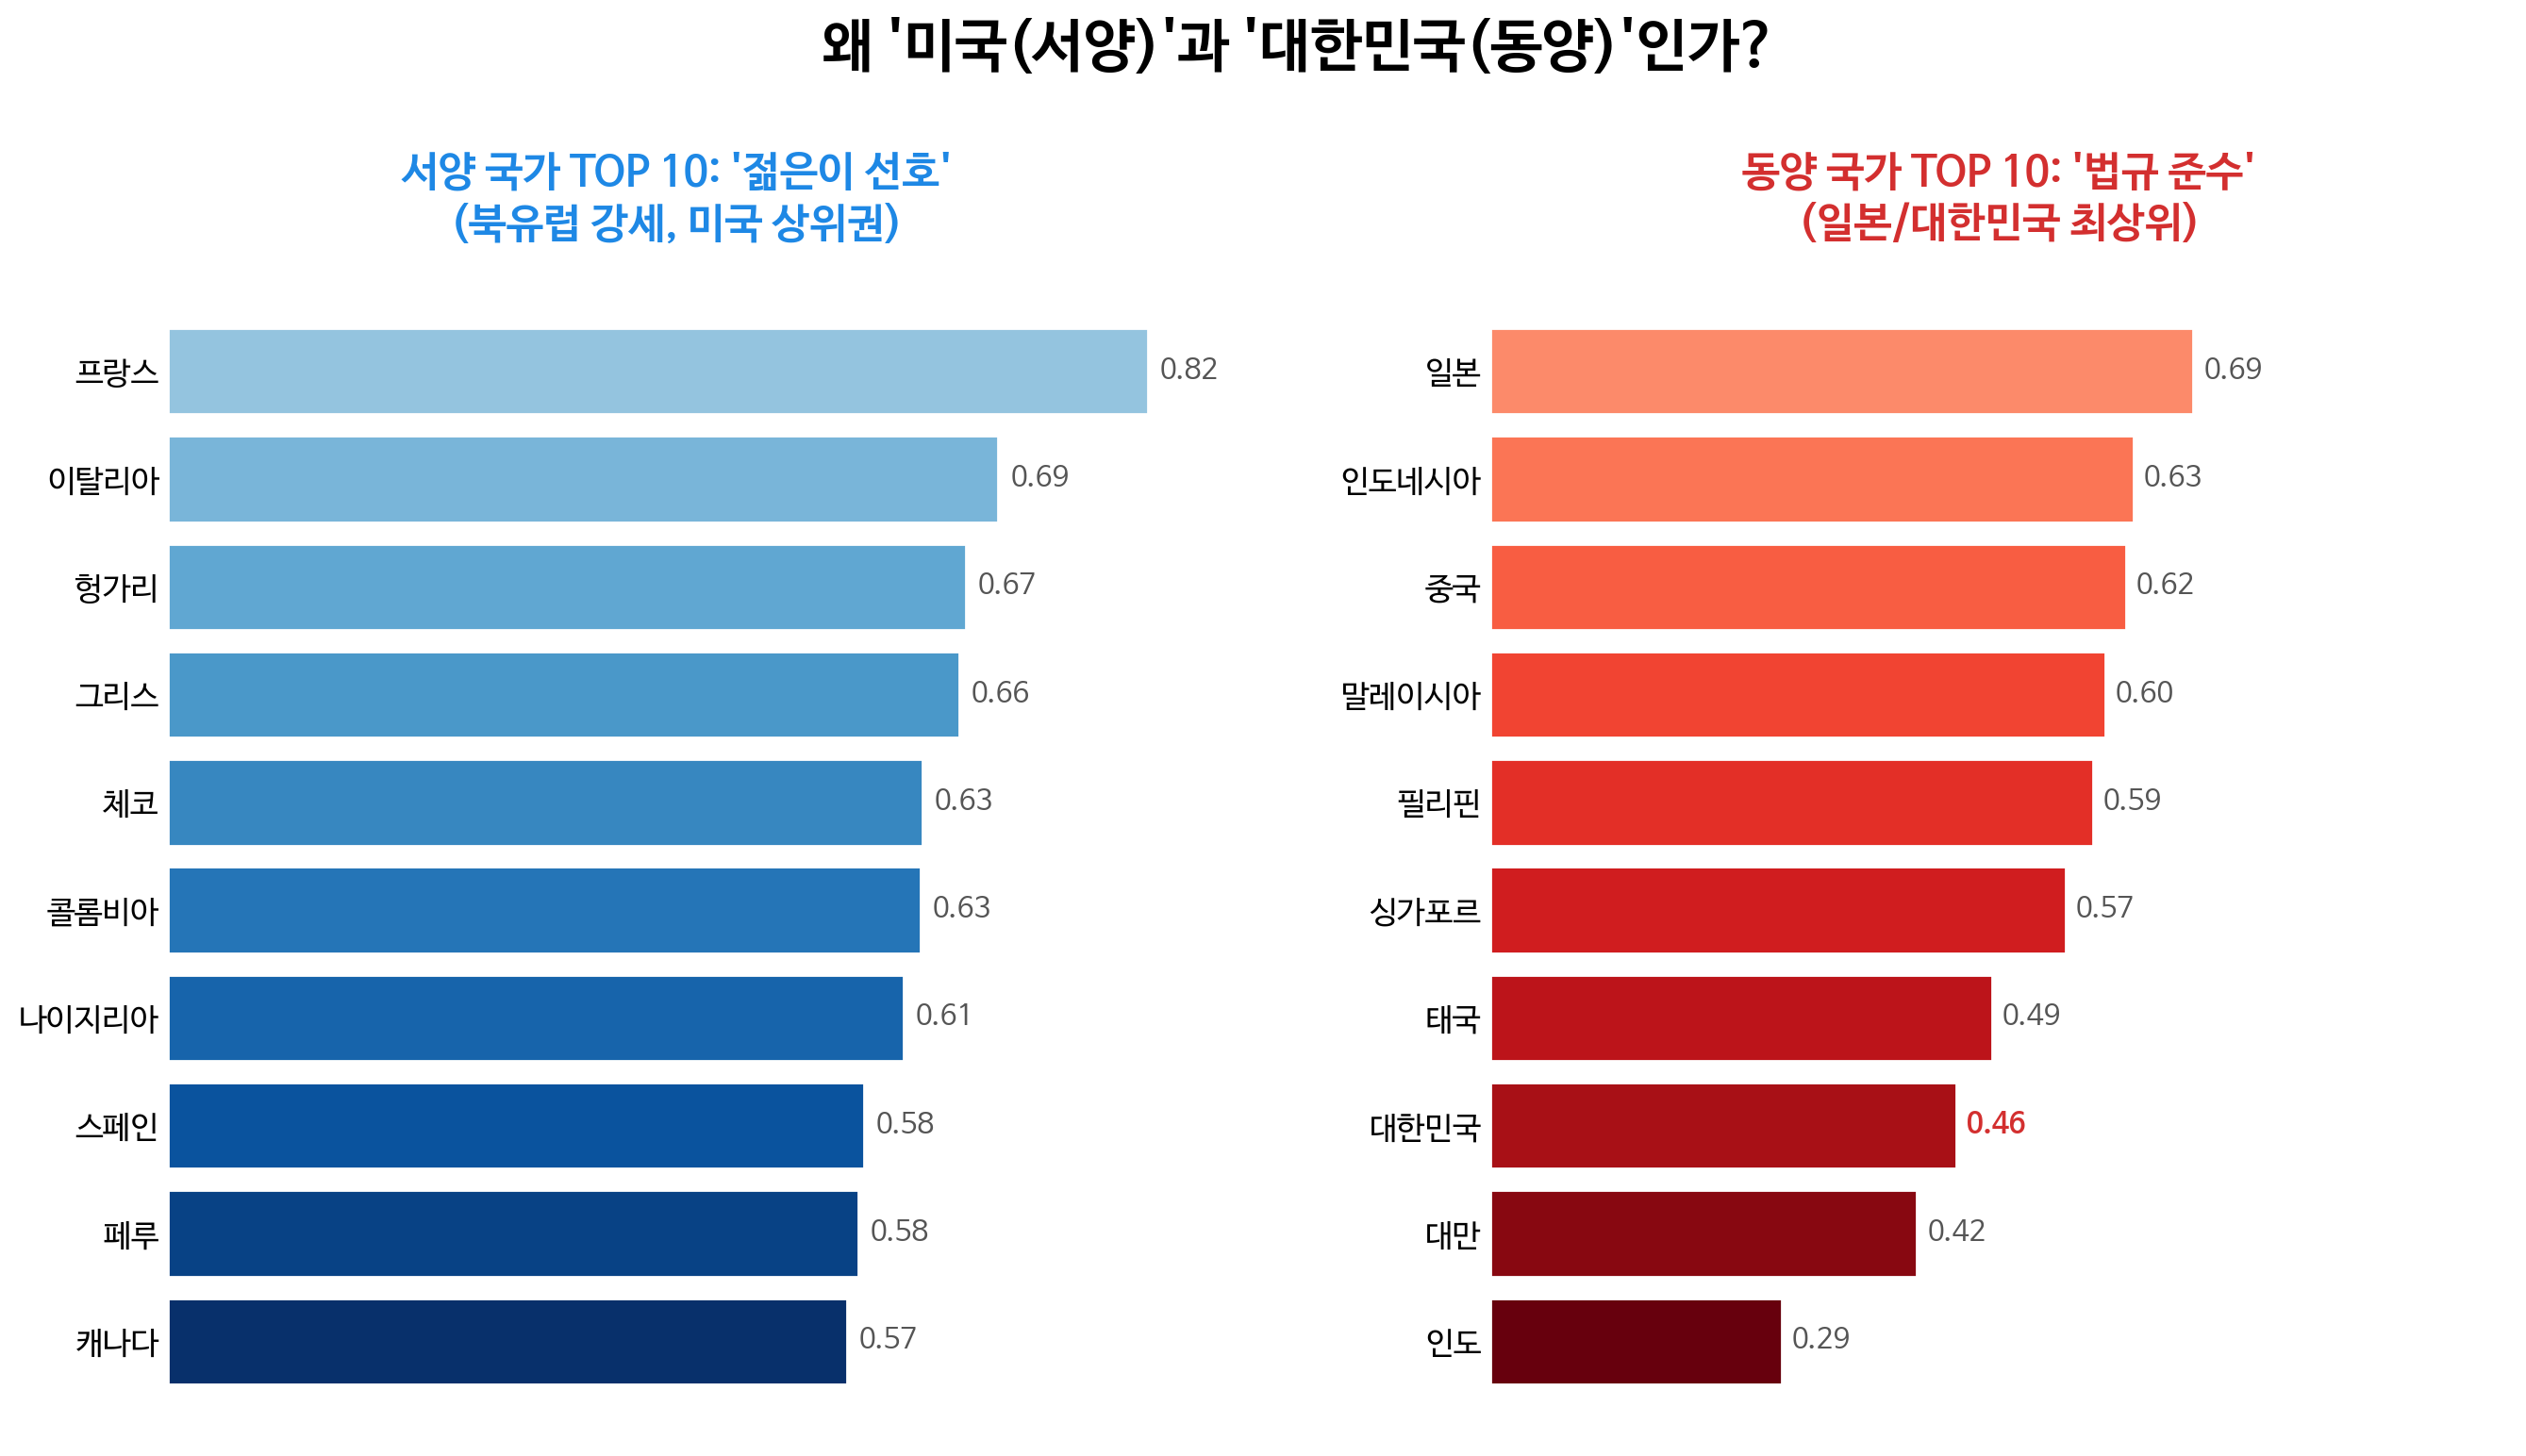

In [10]:
# ==========================================
# [Part 4.5] 중간 분석: 문화권별 대표 국가 선정 (TOP 10)
# ==========================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print("⏳ 챔피언 차트를 생성하고 있습니다...")

# 1. 데이터 분리 (동양/서양)
asian_countries = ['KOR', 'JPN', 'CHN', 'TWN', 'SGP', 'VNM', 'THA', 'IDN', 'PHL', 'MYS', 'IND', 'PAK']
asian_mask = df['ISO3'].isin(asian_countries)
df_asia = df[asian_mask].copy()
df_west = df[~asian_mask].copy()

# 2. 시각화 설정
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
plt.subplots_adjust(wspace=0.3)

# ★ 색상 규칙 통일: 서양(Blue) / 동양(Red)
color_west_blue = '#1E88E5'
color_asia_red = '#D32F2F'

# ---------------------------------------------------------
# [왼쪽] 서양 TOP 10: 젊은이 선호 (파란색 계열)
# ---------------------------------------------------------
top_west = df_west.sort_values(by='save_young', ascending=False).head(10)
countries = top_west['Country']
values = top_west['save_young']

# 그라데이션 적용
cmap_blue = cm.Blues
colors = cmap_blue(np.linspace(0.4, 1.0, len(values)))

axes[0].barh(countries, values, color=colors, edgecolor='white')
axes[0].set_title(f"서양 국가 TOP 10: '젊은이 선호'\n(북유럽 강세, 미국 상위권)", fontsize=16, fontweight='bold', pad=15, color=color_west_blue)
axes[0].invert_yaxis()

# 디자인 정리
for spine in ['top', 'right', 'bottom', 'left']:
    axes[0].spines[spine].set_visible(False)
axes[0].set_xticks([])
axes[0].tick_params(axis='y', length=0, labelsize=12)

# 수치 및 미국 강조
for i, v in enumerate(values):
    color = color_west_blue if countries.iloc[i] == '미국' else '#555555'
    fontweight = 'bold' if countries.iloc[i] == '미국' else 'normal'
    axes[0].text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=11, fontweight=fontweight, color=color)
axes[0].set_xlim(0, 0.85)

# ---------------------------------------------------------
# [오른쪽] 동양 TOP 10: 법규 준수 (빨간색 계열)
# ---------------------------------------------------------
top_asia = df_asia.sort_values(by='compliance', ascending=False).head(10)
countries = top_asia['Country']
values = top_asia['compliance']

# 그라데이션 적용
cmap_red = cm.Reds
colors = cmap_red(np.linspace(0.4, 1.0, len(values)))

axes[1].barh(countries, values, color=colors, edgecolor='white')
axes[1].set_title(f"동양 국가 TOP 10: '법규 준수'\n(일본/대한민국 최상위)", fontsize=16, fontweight='bold', pad=15, color=color_asia_red)
axes[1].invert_yaxis()

for spine in ['top', 'right', 'bottom', 'left']:
    axes[1].spines[spine].set_visible(False)
axes[1].set_xticks([])
axes[1].tick_params(axis='y', length=0, labelsize=12)

# 수치 및 한국 강조
for i, v in enumerate(values):
    color = color_asia_red if countries.iloc[i] == '대한민국' else '#555555'
    fontweight = 'bold' if countries.iloc[i] == '대한민국' else 'normal'
    axes[1].text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=11, fontweight=fontweight, color=color)
axes[1].set_xlim(0, 1.0)

fig.suptitle("왜 '미국(서양)'과 '대한민국(동양)'인가?", fontsize=22, fontweight='bold', y=1.05)
plt.savefig("moral_machine_champions.png", dpi=300, bbox_inches='tight')
plt.show()

⏳ 버터플라이 차트를 생성하고 있습니다...


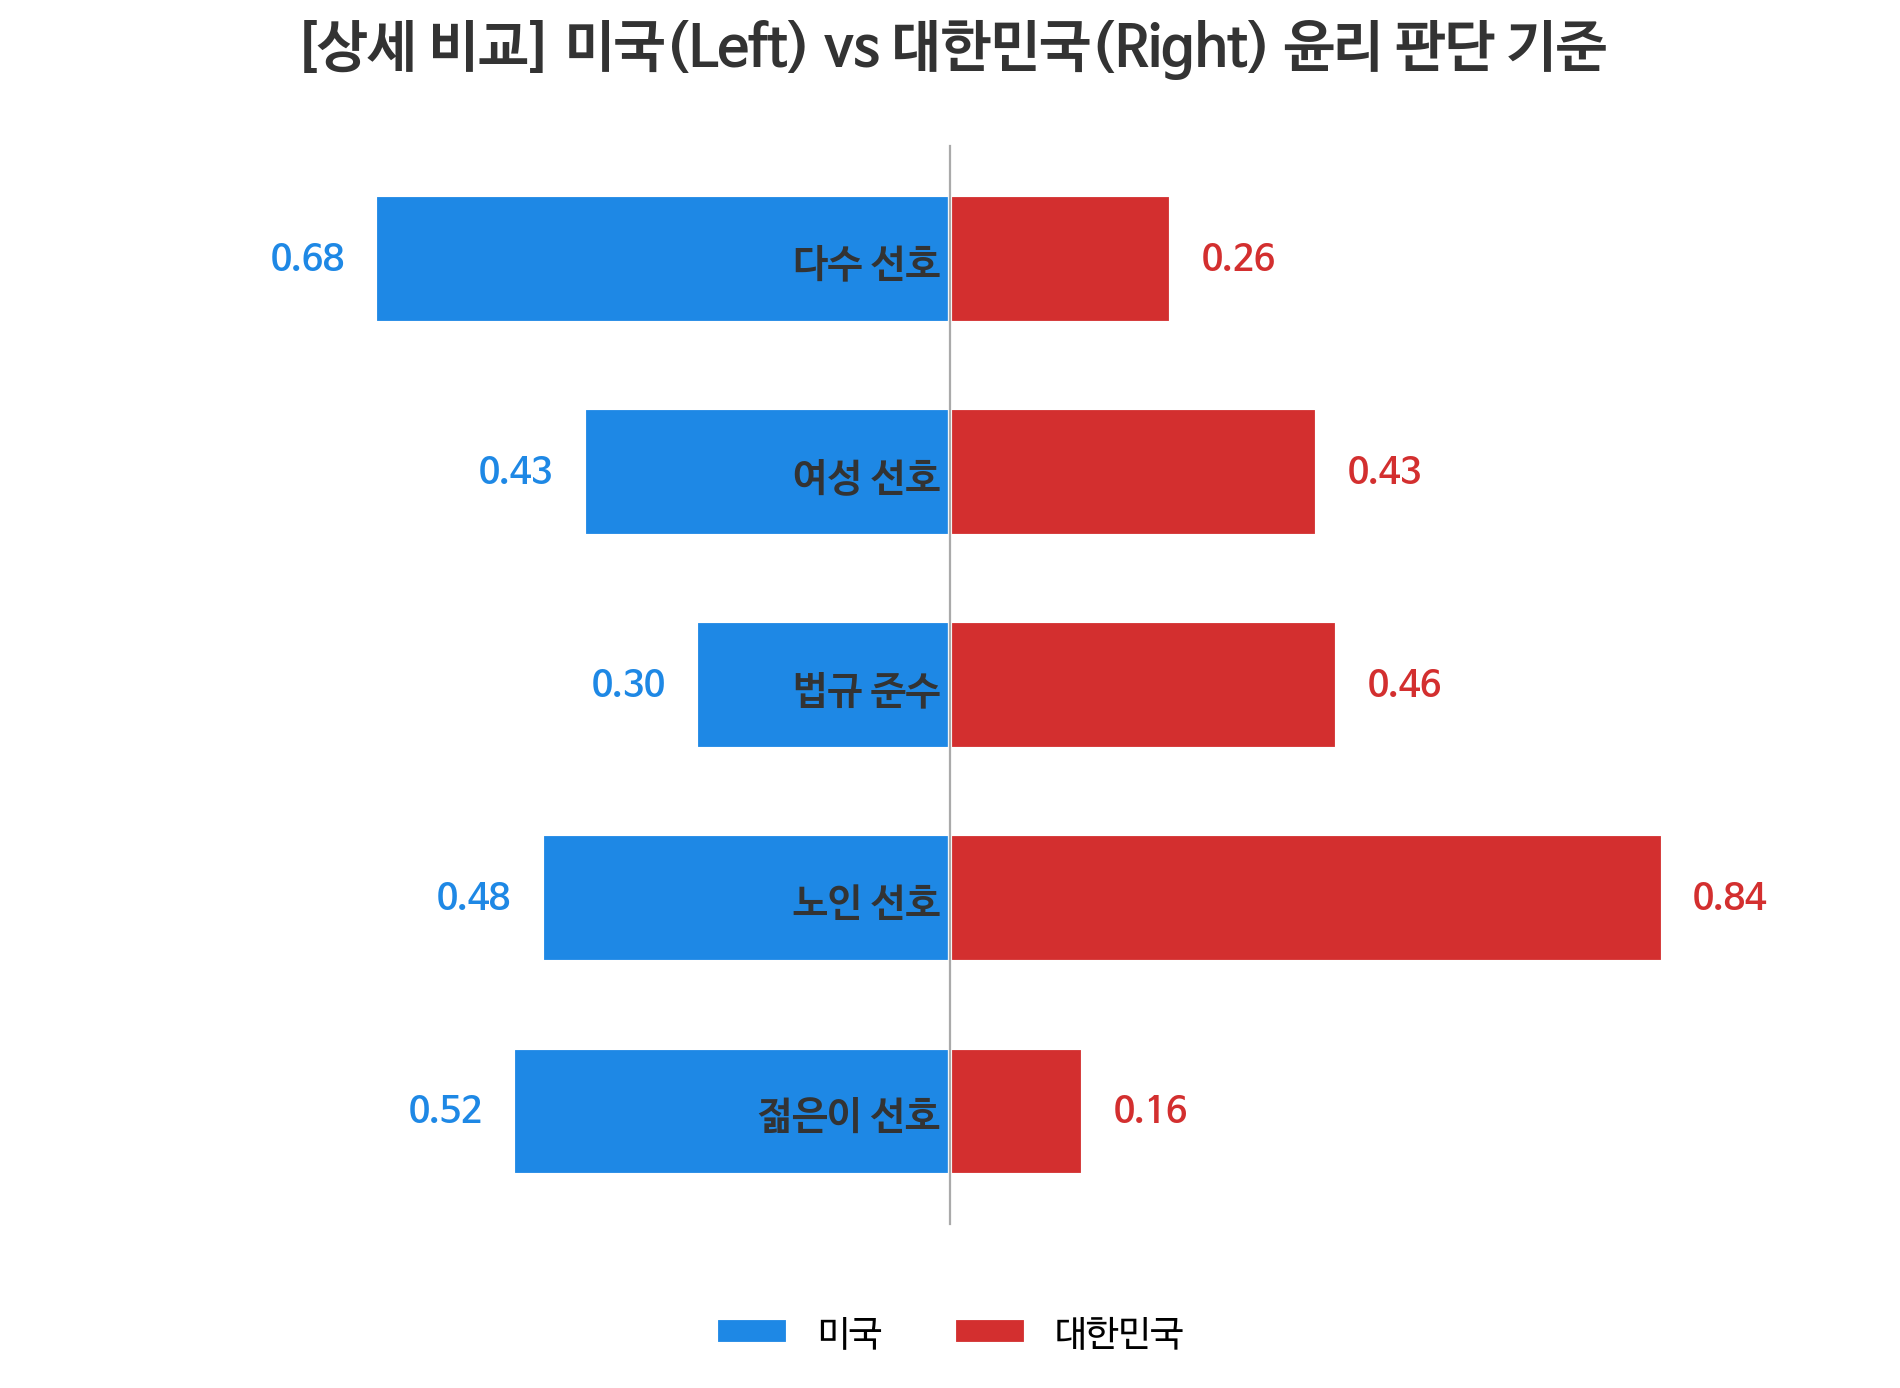

In [ ]:
# ==========================================
# [Part 5] 미시 분석: 버터플라이 차트 (미국 vs 대한민국)
# ==========================================
print("⏳ 버터플라이 차트를 생성하고 있습니다...")
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 준비
target_cols = ['save_young', 'save_elderly', 'compliance', 'save_female', 'save_many']
labels = ['젊은이 선호', '노인 선호', '법규 준수', '여성 선호', '다수 선호']
kor_values = df[df['ISO3'] == 'KOR'][target_cols].values.flatten().tolist()
usa_values = df[df['ISO3'] == 'USA'][target_cols].values.flatten().tolist()

# 2. 디자인 설정
color_kor_red = '#D32F2F'  # 대한민국 (Red)
color_usa_blue = '#1E88E5' # 미국 (Blue)
text_color = '#333333'

# 3. 그래프 그리기
fig, ax = plt.subplots(figsize=(12, 7))
y = np.arange(len(labels))
height = 0.6

# 왼쪽: 미국 (Blue), 오른쪽: 대한민국 (Red)
ax.barh(y, [-x for x in usa_values], height, color=color_usa_blue, label='미국', edgecolor='white', linewidth=1.5)
ax.barh(y, kor_values, height, color=color_kor_red, label='대한민국', edgecolor='white', linewidth=1.5)

# 4. 꾸미기
for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_position('zero')
ax.spines['left'].set_color('#AAAAAA')
ax.grid(axis='x', linestyle='--', alpha=0.7, color='lightgray')
ax.set_xticks([])
ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=14, fontweight='bold', color=text_color)
ax.tick_params(axis='y', length=0)

# 5. 수치 표시
for i, (k, u) in enumerate(zip(kor_values, usa_values)):
    ax.text(-u - 0.08, i, f'{u:.2f}', ha='center', va='center', color=color_usa_blue, fontweight='bold', fontsize=13)
    ax.text(k + 0.08, i, f'{k:.2f}', ha='center', va='center', color=color_kor_red, fontweight='bold', fontsize=13)

# 6. 제목 및 범례
plt.title('[상세 비교] 미국(Left) vs 대한민국(Right) 윤리 판단 기준', fontsize=20, pad=30, fontweight='bold', color=text_color)
handles, labels_legend = ax.get_legend_handles_labels()
ax.legend(handles, labels_legend, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=13, frameon=False)
plt.xlim(-1.1, 1.1)

plt.savefig("moral_machine_butterfly_design.png", dpi=300, bbox_inches='tight')
plt.show()